# Simulation of batch experiment

In [20]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

import cobra
import reframed
from cobra.io import load_model
import pandas as pd

import sys
sys.path.append("../functions/")

%load_ext autoreload
%autoreload 2

import dfba_cobra_cellulose

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Prepare for simulation

In [21]:
cellulose_exp = pd.read_csv("../input/Desvaux2001_batch_data/cellulose_g.csv")
biomass_exp = pd.read_csv("../input/Desvaux2001_batch_data/biomass_mg.csv")
ethanol = pd.read_csv("../input/Desvaux2001_batch_data/ethanol_mmol.csv")
acetate = pd.read_csv("../input/Desvaux2001_batch_data/acetate_mmol.csv")
lactate = pd.read_csv("../input/Desvaux2001_batch_data/lactate_mmol.csv")
pyruvate = pd.read_csv("../input/Desvaux2001_batch_data/pyruvate_umol.csv")

**Calculate specific production rates**

In [22]:
diff_bio = ((biomass_exp[biomass_exp.x<70].shift(-1)[" y"]-biomass_exp[biomass_exp.x<70][" y"]).mean()/1000)
diff_ac = (acetate[acetate.x<70].shift(-1)[" y"]-acetate[acetate.x<70][" y"]).mean()
diff_lac = (lactate[lactate.x<70].shift(-1)[" y"]-lactate[lactate.x<70][" y"]).mean()
diff_etoh = (ethanol[ethanol.x<70].shift(-1)[" y"]-ethanol[ethanol.x<70][" y"]).mean()
diff_pyr = (pyruvate[pyruvate.x<70].shift(-1)[" y"]-pyruvate[pyruvate.x<70][" y"]).mean()/1000

In [23]:
model = reframed.load_cbmodel("../models/RcH10_final.xml")
model.reactions.R_EX_gal_e.ub=0
model.reactions.R_EX_rib__D_e.ub=0
model.add_ratio_constraint("R_Growth","R_EX_ac_e",round((diff_bio/diff_ac),2))
model.add_ratio_constraint("R_Growth","R_EX_etoh_e",round(diff_bio/diff_etoh,2)) 
model.add_ratio_constraint("R_Growth","R_EX_lac__L_e",round(diff_bio/diff_lac,2)) 
model.add_ratio_constraint("R_Growth","R_EX_pyr_e",round(diff_ac/diff_pyr,2)) 

reframed.save_cbmodel(model,"../models/RcH10_final_flux_ratio.xml")

model = cobra.io.read_sbml_model('../models/RcH10_final_flux_ratio.xml')
 
medium = model.medium

medium["EX_glc__D_e"]=10.0
model.medium = medium
cobra.util.add_lp_feasibility(model)

In [24]:

ts = np.linspace(0, 150, 1000)  # Desired integration resolution and interval

y0 = [0.02,0,0,0,0,0,0,38.53897]

rxns = ["Growth","EX_glc__D_e","EX_cellb_e","EX_ac_e","EX_etoh_e","EX_lac__L_e","EX_pyr_e"]
objective_dir = ["max","max","max","min","min","min","min"]


with tqdm() as pbar:
    dfba_cobra_cellulose.dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dfba_cobra_cellulose.dynamic_system,
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        method='LSODA',
        events = [dfba_cobra_cellulose.infeasible_event],
        args = (model,rxns,objective_dir,)
    )

t = 73.847: : 354it [00:55,  6.41it/s]


#### Process data and plot results

In [25]:

rxns_map = rxns.copy()
rxns_map.append("EX_cellulose_e")
C_results = dict(zip(rxns_map,sol.y))

t_extend = np.linspace(sol.t[-1],150)[1:]
C_extend = {rxn:np.array([c[-1] for item in t_extend]) for rxn,c in C_results.items()}


## Before growth hault
names = []
C_time_series = {}
for key,values in C_results.items():
    if key!="EX_cellulose_e" and key!="Growth":
        met = model.reactions.get_by_id(key)
        met_name = list(met.metabolites.keys())[0].name
    elif key=="EX_cellulose_e":
        met_name = "Cellulose (hexose eq.)"
    elif key=="Growth":
        met_name = "Biomass"
    C_time_series[met_name]=values
    
C_df = pd.DataFrame(C_time_series)
C_df.index = sol.t
molar_mass = 173.85  # Based on glucose equivalent (based on 0.35 cellobiose and 0.3 glucose)
C_df["Cellulose (hexose eq.)"] = C_df["Cellulose (hexose eq.)"]*molar_mass/1000 # [g]


## After growth stop
C_time_series_2 = {}
for key,values in C_extend.items():
    if key!="EX_cellulose_e" and key!="Growth":
        met = model.reactions.get_by_id(key)
        met_name = list(met.metabolites.keys())[0].name
    elif key=="EX_cellulose_e":
        met_name = "Cellulose (hexose eq.)"
    elif key=="Growth":
        met_name = "Biomass"
    C_time_series_2[met_name]=values
  
C_df2 = pd.DataFrame(C_time_series_2)
C_df2.index = t_extend
molar_mass = 173.85  # Based on glucose equivalent (based on 0.35 cellobiose and 0.3 glucose)
C_df2["Cellulose (hexose eq.)"] = C_df2["Cellulose (hexose eq.)"]*molar_mass/1000 # [g]

In [26]:
cellobiose = pd.read_csv("../input/Desvaux2001_batch_data/cellobiose_mmol.csv")
glucose = pd.read_csv("../input/Desvaux2001_batch_data/glucose_mmol.csv")


In [27]:
from matplotlib.gridspec import GridSpec

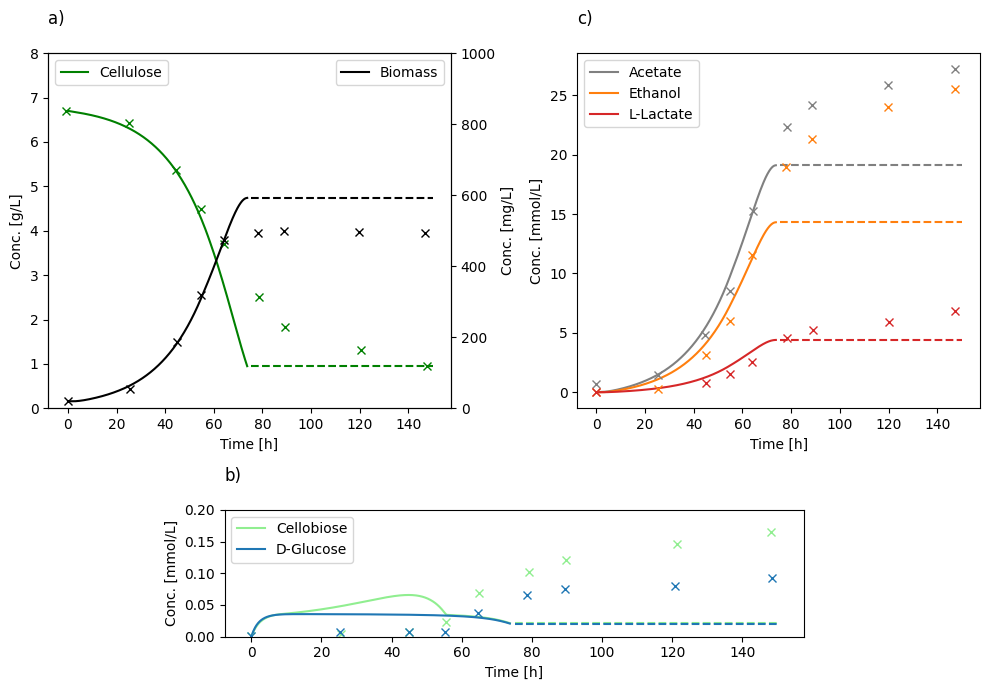

In [28]:
fig = plt.figure(figsize=(10,7))
gs = GridSpec(3,6,figure=fig)
ax1 = fig.add_subplot(gs[0:2, 0:3])
ax3 = fig.add_subplot(gs[2:3,1:5])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax4 = fig.add_subplot(gs[0:2,3:])


C_df.loc[:,["Cellulose (hexose eq.)"]].plot(ax=ax1,xlabel="Time [h]",ylabel="Conc. [g/L]",color="green")
C_df2.loc[:,["Cellulose (hexose eq.)"]].plot(ax=ax1,xlabel="Time [h]",ylabel="Conc. [g/L]",color="green",linestyle="--")

ax1.plot(cellulose_exp["x"].values,cellulose_exp[" y"].values,'x',color="green")
ax1.set_ylim([0,8])
ax1.legend(["Cellulose"],loc="upper left")
ax1_twin = ax1.twinx()
pd.Series(index=C_df.index,data=np.array(C_df["Biomass"])*1000).plot(ax=ax1_twin,xlabel="Time [h]",ylabel="Conc. [mg/L]",color="black") #1000
pd.Series(index=C_df2.index,data=np.array(C_df2["Biomass"])*1000).plot(ax=ax1_twin,xlabel="Time [h]",ylabel="Conc. [mg/L]",color="black",linestyle="--") #1000
ax1_twin.plot(biomass_exp["x"].values,biomass_exp[" y"].values,'x',color="black",)
ax1_twin.set_ylim([0,1000])
ax1_twin.legend(["Biomass"])

C_df.loc[:,["Cellobiose","D-Glucose"]].plot(ax=ax3,ylim=[0,0.2],color=["lightgreen","tab:blue"],xlabel="Time [h]",ylabel="Conc. [mmol/L]")
C_df2.loc[:,["Cellobiose","D-Glucose"]].plot(ax=ax3,ylim=[0,0.2],color=["lightgreen","tab:blue"],xlabel="Time [h]",ylabel="Conc. [mmol/L]",linestyle="--",legend=False)

ax3.plot(cellobiose["x"].values,cellobiose[" y"].values,'x',color="lightgreen")
ax3.plot(glucose["x"].values,glucose[" y"].values,'x',color="tab:blue")

C_df.loc[:,["Acetate","Ethanol","L-Lactate"]].plot(ax=ax4,color=["grey","tab:orange","tab:red"],xlabel="Time [h]",ylabel="Conc. [mmol/L]")
C_df2.loc[:,["Acetate","Ethanol","L-Lactate"]].plot(ax=ax4,color=["grey","tab:orange","tab:red"],xlabel="Time [h]",ylabel="Conc. [mmol/L]",linestyle="--",legend=False)

ax4.plot(acetate["x"].values,acetate[" y"].values,'x',color="grey")
ax4.plot(ethanol["x"].values,ethanol[" y"].values,'x',color="tab:orange")
ax4.plot(lactate["x"].values,lactate[" y"].values,'x',color="tab:red")

ax1.set_title("a)\n",loc="left")
ax3.set_title("b)\n",loc="left")
ax4.set_title("c)\n",loc="left")

plt.tight_layout()
plt.savefig("../figures/batch_replication.png")